In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, './')

def generateModelV2(working_directory, 
                    number_directory=0, 
                    number_images=0,
                    #number_cluster=10,
                    descriptor_generator="SIFT", 
                    number_feature=200,
                    minimum_size_descriptor=20, 
                    #mode_affichage=""
                   ):
    start_time_model = time.time()

    # class de travail
    from Python.automaticImageIndexing import AutomaticImageIndexing
    automaticImageIndexing = AutomaticImageIndexing()

    print(''.join(['Version : ', automaticImageIndexing.version()]))
    print(''.join(['Data directory : ', automaticImageIndexing.data_directory]))

    automaticImageIndexing.n_limite_directories = number_directory
    automaticImageIndexing.n_limite_images = number_images
    print(''.join(['Max Number of directory : ', str(automaticImageIndexing.n_limite_directories)]))
    print(''.join(['Max Number of picture by directory : ', str(automaticImageIndexing.n_limite_images)]))

    automaticImageIndexing.working_directory = working_directory#'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
    automaticImageIndexing.annotation_directory = 'annotation/'
    automaticImageIndexing.picture_directory = 'images/'
    
    automaticImageIndexing.feature_generator = descriptor_generator
    print('Generator : %s' % automaticImageIndexing.feature_generator)
    automaticImageIndexing.n_feature = number_feature 
    print('Number of feature : %d' % automaticImageIndexing.n_feature)
    automaticImageIndexing.feature_size_min = minimum_size_descriptor
    print('Minimum feature size  %d' % automaticImageIndexing.n_feature)
    
    automaticImageIndexing.read_picture_and_feature_generation(with_sub_picture=True, descriptor_generator=descriptor_generator)
    print("Temps d execution apres parcour image + ORB : %s secondes ---" % (time.time() - start_time_model))

    return automaticImageIndexing

def generateCluster(automaticImageIndexing, number_cluster=None, mode_affichage="", number_cluster_to_show=None):
    start_time_cluster = time.time()
    if(number_cluster is None):
        number_cluster = int(10)
    automaticImageIndexing.n_clusters = number_cluster
    
    automaticImageIndexing.clusturing(automaticImageIndexing.n_clusters)
    print("Temps d execution apres Clustering : %s secondes ---" % (time.time() - start_time_cluster))
    mega_histo = automaticImageIndexing.developBagOfVisualWord()
    print("Temps d execution apres BOV : %s secondes ---" % (time.time() - start_time_cluster))
    automaticImageIndexing.plotHist(mega_histo, automaticImageIndexing.n_clusters, None)
    print("Temps d execution après plot BOV : %s secondes ---" % (time.time() - start_time_cluster))

    if number_cluster_to_show is None :
        number_cluster_to_show = int(number_cluster/2)
    showClusterPicture(
        automaticImageIndexing=automaticImageIndexing,
        mode_affichage=mode_affichage,
        number_cluster_to_show=number_cluster_to_show
    )

def showClusterPicture(automaticImageIndexing, mode_affichage="", number_cluster_to_show=None):
    start_time_showing = time.time()

    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (& generer les cluster) ---")
    else:
        if number_cluster_to_show is None :
            number_cluster_to_show = int(automaticImageIndexing.n_clusters/2)

        if (mode_affichage == "subplot" or mode_affichage == "all"):
            print("affichage subplot des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_subplot_V2(number_cluster_to_show)
            print("Temps d execution apres subplot : %s secondes ---" % (time.time() - start_time_showing))

        if (mode_affichage == "individual_plot" or mode_affichage == "all"):
            print("affichage individuel des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_individualplot(number_cluster_to_show)        
            print("Temps d execution apres individual_plot : %s secondes ---" % (time.time() - start_time_showing))
    


In [3]:
def k_mean_distance_decriptor(data, cantroid_matrix, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances), np.min(distances), np.max(distances), len(distances)

def k_mean_distance_all_cluster(model):
    distances = []
    clusters_rates = []
    data = model.np.array(model.desc_list)
    for i_centroid, cantroid_matrix in enumerate(model.kmeans_obj.cluster_centers_):
        # Calculate Euclidean distance for each data point assigned to centroid
        distances = distances + [model.np.linalg.norm(x-cantroid_matrix) for x in data[model.kmeans_ret == i_centroid]]
        # Calculate the rate of cluster for each centroid
        clusters_rates.append(len(data[model.kmeans_ret == i_centroid]))
    return model.np.mean(distances), model.np.min(distances), model.np.max(distances), model.np.mean(clusters_rates)

def findBestCluster(automaticImageIndexing, number_cluster_min=0, number_cluster_max=100, number_cluster_step=25, show_intermediate_distance=None):
    start_time_cluster_optimizing = time.time()
    
    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (et generer les clusters) ---")
    else:
        result = []
        nb_descriptor_total = len(automaticImageIndexing.desc_list) * 1.0 #1.0 to convert int in decimal
        print("nb descriptor : %s" % nb_descriptor_total)
        
        mean_distances_all_cluster = []
        max_distances_all_cluster = []
        min_distances_all_cluster = []
        perform_indicator_nb_descriptor_all_cluster=[]
        perform_indicator_descripor_all_cluster=[]

        for nb_cluster in range(number_cluster_min, number_cluster_max, number_cluster_step):
            print("-----------------------------------------------------------------------------------------")
            print("--------------------------------- start test cluster %s ---------------------------------" % str(nb_cluster))
            generateCluster(
                automaticImageIndexing=automaticImageIndexing,
                number_cluster=nb_cluster
            )
            
            centroids = model.kmeans_obj.cluster_centers_            
            if show_intermediate_distance == True:
                mean_distances = []
                max_distances = []
                min_distances = []
                descriptors_rate = []
                for i, cent_features in enumerate(centroids):
                    mean_distance, max_distance, min_distance, number_descriptor = k_mean_distance_decriptor(
                        automaticImageIndexing.np.array(automaticImageIndexing.desc_list), 
                        cent_features,
                        i,
                        automaticImageIndexing.kmeans_ret
                    )
                    mean_distances.append(mean_distance)
                    max_distances.append(max_distance)
                    min_distances.append(min_distance)
                    
                    perform_indicator_descripor = (number_descriptor / nb_descriptor_total)
                    descriptors_rate.append(perform_indicator_descripor)
                fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
                clusters_numero = range(nb_cluster)
                axs[0].plot(clusters_numero, mean_distances)
                axs[0].plot(clusters_numero, max_distances)
                axs[0].plot(clusters_numero, min_distances)
                
                axs[0].set_xlabel('Cluster', fontsize=12)
                axs[0].set_ylabel('Distance', fontsize=12)
                axs[0].set_title('Distances by Cluster', fontsize=12)
                
                axs[1].plot(clusters_numero, descriptors_rate)
                
                axs[1].set_xlabel('Cluster', fontsize=12)
                axs[1].set_ylabel('Descriptor Rate', fontsize=12)
                axs[1].set_title('Descriptor Rate by cluster', fontsize=12)
                automaticImageIndexing.plt.show()
            
            mean_distance_all_cluster, max_distance_all_cluster, min_distance_all_cluster, mean_number_descriptor = k_mean_distance_all_cluster(
                automaticImageIndexing
            )
            mean_distances_all_cluster.append(mean_distance_all_cluster)
            max_distances_all_cluster.append(max_distance_all_cluster)
            min_distances_all_cluster.append(min_distance_all_cluster)
            
            print(mean_number_descriptor)
            print(nb_descriptor_total)
            
            print(mean_number_descriptor / nb_descriptor_total)
            
            perform_indicator_distance = mean_number_descriptor / nb_descriptor_total
            
            perform_indicator_nb_descriptor_all_cluster.append(perform_indicator_distance)
            
            print("--------------------------------- sop test cluster %s ---------------------------------" % str(nb_cluster))
    clusters_numbers = range(number_cluster_min, number_cluster_max, number_cluster_step)
    
    fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
    axs[0].plot(clusters_numbers, mean_distances_all_cluster, label="mean")
    axs[0].plot(clusters_numbers, max_distances_all_cluster, label="max")
    axs[0].plot(clusters_numbers, min_distances_all_cluster, label="min")

    axs[0].set_xlabel('Cluster', fontsize=12)
    axs[0].set_ylabel('Distance moyenne', fontsize=12)
    axs[0].set_title('Distances moyenne by number of Cluster', fontsize=12)

    axs[1].plot(clusters_numbers, perform_indicator_nb_descriptor_all_cluster, label="indicateur Nb Descripteur moyen")

    axs[1].set_xlabel('Cluster', fontsize=12)
    axs[1].set_ylabel('Descriptor Rate', fontsize=12)
    axs[1].set_title('Descriptor Rate by number of Cluster', fontsize=12)
    #automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.multiply(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.multiply(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.multiply(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    print("Temps d execution optimisation : %s secondes ---" % (time.time() - start_time_cluster_optimizing))


Version : 0.3
Data directory : Data/
Max Number of directory : 2
Max Number of picture by directory : 2
Generator : ORB
Number of feature : 60
Minimum feature size  60
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Temps d execution apres parcour image + ORB : 0.131000041962 secondes ---
nb descriptor : 181.0
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 1 ---------------------------------
Temps d execution apres Clustering : 0.0179998874664 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0190000534058 secondes ---
Plotting histogram


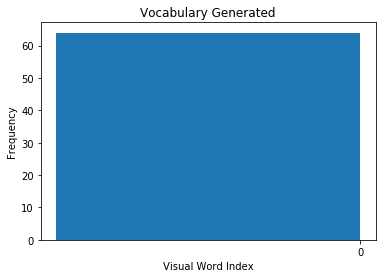

Temps d execution après plot BOV : 0.217000007629 secondes ---


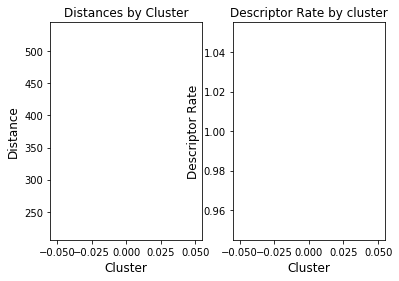

181.0
181.0
1.0
--------------------------------- sop test cluster 1 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 2 ---------------------------------
Temps d execution apres Clustering : 0.0469999313354 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0469999313354 secondes ---
Plotting histogram


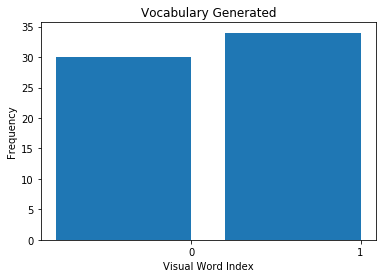

Temps d execution après plot BOV : 0.269000053406 secondes ---


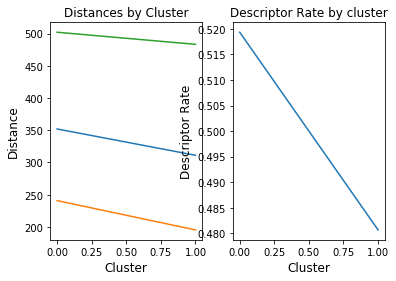

90.5
181.0
0.5
--------------------------------- sop test cluster 2 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 3 ---------------------------------
Temps d execution apres Clustering : 0.0369999408722 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.0369999408722 secondes ---
Plotting histogram


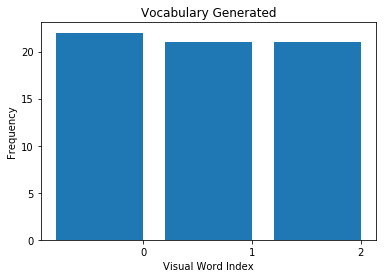

Temps d execution après plot BOV : 0.256999969482 secondes ---


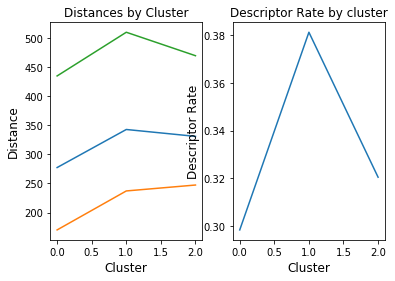

60.333333333333336
181.0
0.33333333333333337
--------------------------------- sop test cluster 3 ---------------------------------


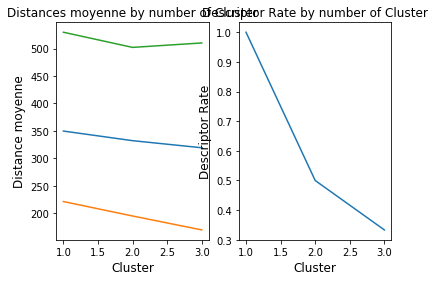

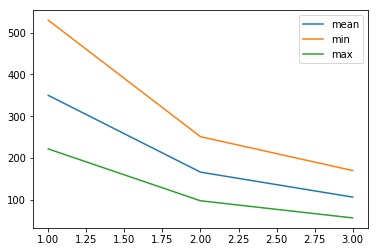

Temps d execution optimisation : 3.60500001907 secondes ---


In [7]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=2,#40, 
        number_images=2,#20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 1
stop = 4
step = 1
tableau_perf = findBestCluster(model, start, stop, step,
        show_intermediate_distance=True)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 100
Max Number of picture by directory : 2
Generator : ORB
Number of feature : 75
Minimum feature size  75
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-re

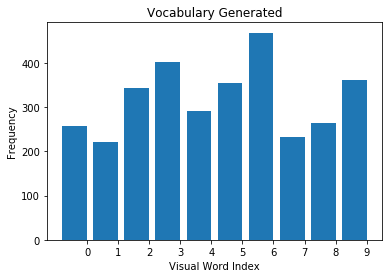

Temps d execution après plot BOV : 4.50500011444 secondes ---
1403.1
14031.0
0.09999999999999999
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 13.3169999123 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 13.3250000477 secondes ---
Plotting histogram


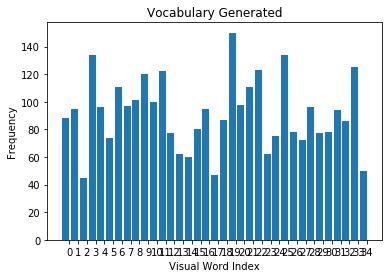

Temps d execution après plot BOV : 13.5929999352 secondes ---
400.8857142857143
14031.0
0.028571428571428574
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 15.6339998245 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 15.6410000324 secondes ---
Plotting histogram


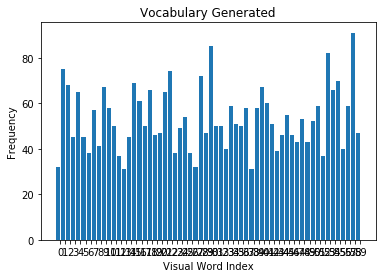

Temps d execution après plot BOV : 16.1619999409 secondes ---
233.85
14031.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 21.1819999218 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 21.1819999218 secondes ---
Plotting histogram


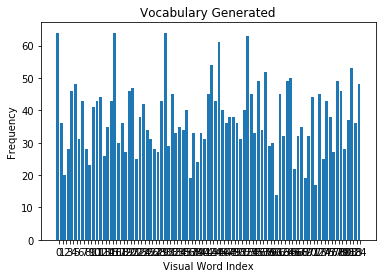

Temps d execution après plot BOV : 22.0099999905 secondes ---
165.0705882352941
14031.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------
Temps d execution apres Clustering : 26.0510001183 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 26.0590000153 secondes ---
Plotting histogram


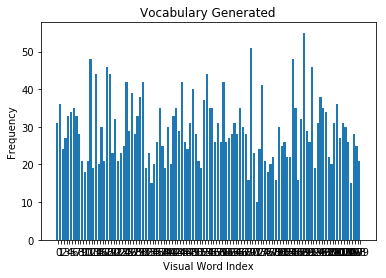

Temps d execution après plot BOV : 27.2139999866 secondes ---
127.55454545454545
14031.0
0.00909090909090909
--------------------------------- sop test cluster 110 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 135 ---------------------------------
Temps d execution apres Clustering : 32.0090000629 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 32.0169999599 secondes ---
Plotting histogram


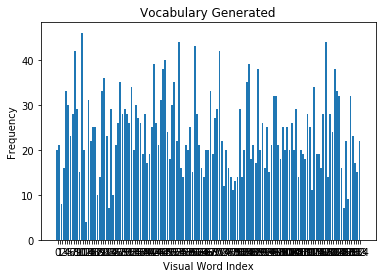

Temps d execution après plot BOV : 33.4800000191 secondes ---
103.93333333333334
14031.0
0.007407407407407408
--------------------------------- sop test cluster 135 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 160 ---------------------------------
Temps d execution apres Clustering : 41.864000082 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 41.871999979 secondes ---
Plotting histogram


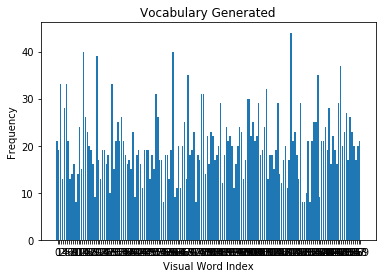

Temps d execution après plot BOV : 44.1229999065 secondes ---
87.69375
14031.0
0.0062499999999999995
--------------------------------- sop test cluster 160 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 185 ---------------------------------
Temps d execution apres Clustering : 52.7690000534 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 52.7799999714 secondes ---
Plotting histogram


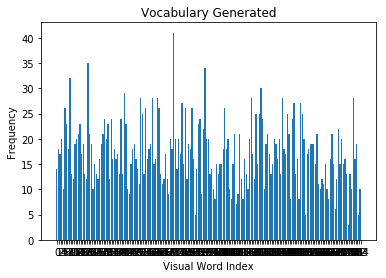

Temps d execution après plot BOV : 57.0439999104 secondes ---
75.84324324324324
14031.0
0.005405405405405405
--------------------------------- sop test cluster 185 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 210 ---------------------------------
Temps d execution apres Clustering : 59.5629999638 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 59.5710000992 secondes ---
Plotting histogram


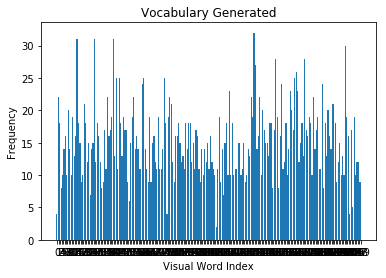

Temps d execution après plot BOV : 62.5910000801 secondes ---
66.81428571428572
14031.0
0.004761904761904762
--------------------------------- sop test cluster 210 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 235 ---------------------------------
Temps d execution apres Clustering : 63.6410000324 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 63.6519999504 secondes ---
Plotting histogram


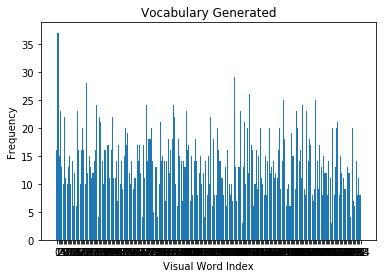

Temps d execution après plot BOV : 68.1349999905 secondes ---
59.706382978723404
14031.0
0.00425531914893617
--------------------------------- sop test cluster 235 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 260 ---------------------------------
Temps d execution apres Clustering : 98.0819997787 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 98.0909998417 secondes ---
Plotting histogram


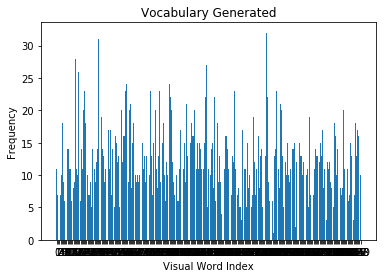

Temps d execution après plot BOV : 101.944999933 secondes ---
53.965384615384615
14031.0
0.003846153846153846
--------------------------------- sop test cluster 260 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 285 ---------------------------------
Temps d execution apres Clustering : 80.3149998188 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 80.3279998302 secondes ---
Plotting histogram


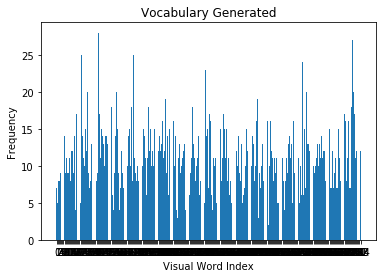

Temps d execution après plot BOV : 85.1799998283 secondes ---
49.23157894736842
14031.0
0.0035087719298245615
--------------------------------- sop test cluster 285 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 310 ---------------------------------
Temps d execution apres Clustering : 67.5500001907 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 67.5580000877 secondes ---
Plotting histogram


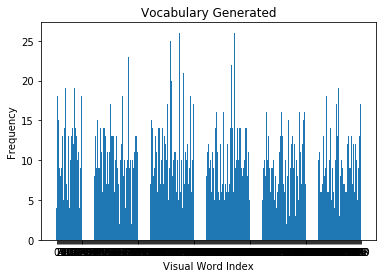

Temps d execution après plot BOV : 71.8120000362 secondes ---
45.26129032258064
14031.0
0.003225806451612903
--------------------------------- sop test cluster 310 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 335 ---------------------------------
Temps d execution apres Clustering : 74.3289999962 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 74.3380000591 secondes ---
Plotting histogram


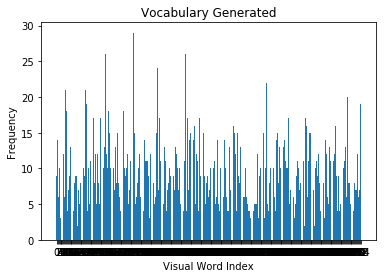

Temps d execution après plot BOV : 78.9120001793 secondes ---
41.88358208955224
14031.0
0.0029850746268656717
--------------------------------- sop test cluster 335 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 360 ---------------------------------
Temps d execution apres Clustering : 69.4279999733 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 69.4360001087 secondes ---
Plotting histogram


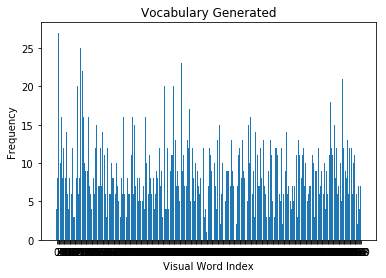

Temps d execution après plot BOV : 75.1730000973 secondes ---
38.975
14031.0
0.002777777777777778
--------------------------------- sop test cluster 360 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 385 ---------------------------------
Temps d execution apres Clustering : 78.0879998207 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 78.1009998322 secondes ---
Plotting histogram


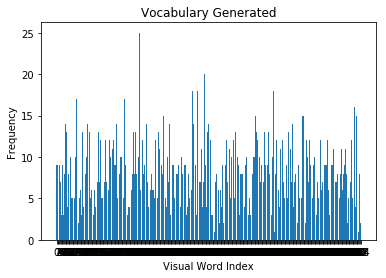

Temps d execution après plot BOV : 83.4989998341 secondes ---
36.444155844155844
14031.0
0.0025974025974025974
--------------------------------- sop test cluster 385 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 410 ---------------------------------
Temps d execution apres Clustering : 88.3099999428 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 88.3200001717 secondes ---
Plotting histogram


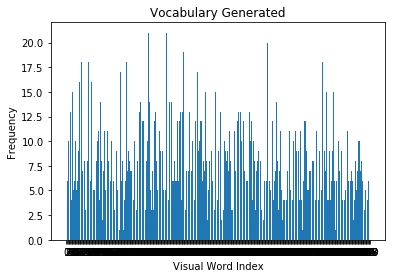

Temps d execution après plot BOV : 95.8600001335 secondes ---
34.22195121951219
14031.0
0.0024390243902439024
--------------------------------- sop test cluster 410 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 435 ---------------------------------
Temps d execution apres Clustering : 89.0320000648 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 89.0320000648 secondes ---
Plotting histogram


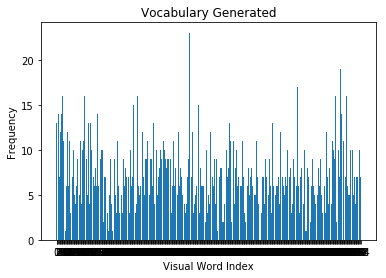

Temps d execution après plot BOV : 93.1050000191 secondes ---
32.255172413793105
14031.0
0.0022988505747126436
--------------------------------- sop test cluster 435 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 460 ---------------------------------
Temps d execution apres Clustering : 71.3440001011 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 71.3519999981 secondes ---
Plotting histogram


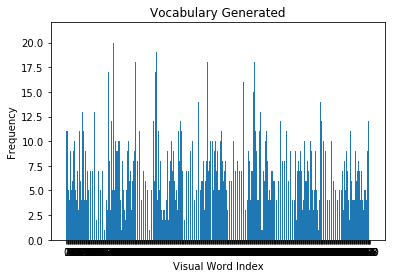

Temps d execution après plot BOV : 75.4700000286 secondes ---
30.502173913043478
14031.0
0.002173913043478261
--------------------------------- sop test cluster 460 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 485 ---------------------------------
Temps d execution apres Clustering : 74.5450000763 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 74.5529999733 secondes ---
Plotting histogram


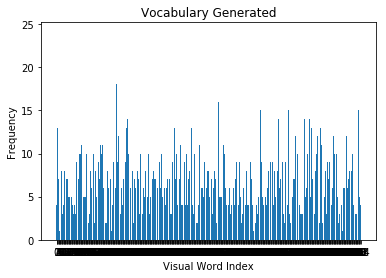

Temps d execution après plot BOV : 78.9140000343 secondes ---
28.929896907216495
14031.0
0.002061855670103093
--------------------------------- sop test cluster 485 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 510 ---------------------------------
Temps d execution apres Clustering : 74.228000164 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 74.2369999886 secondes ---
Plotting histogram


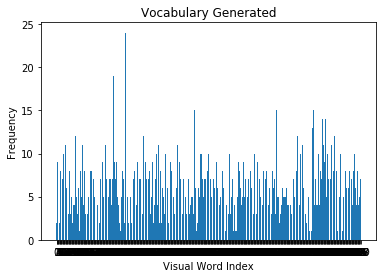

Temps d execution après plot BOV : 79.986000061 secondes ---
27.511764705882353
14031.0
0.00196078431372549
--------------------------------- sop test cluster 510 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 535 ---------------------------------
Temps d execution apres Clustering : 76.1740000248 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 76.1830000877 secondes ---
Plotting histogram


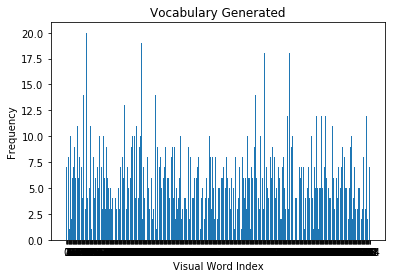

Temps d execution après plot BOV : 82.0780000687 secondes ---
26.226168224299066
14031.0
0.001869158878504673
--------------------------------- sop test cluster 535 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 560 ---------------------------------
Temps d execution apres Clustering : 78.5499999523 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 78.5590000153 secondes ---
Plotting histogram


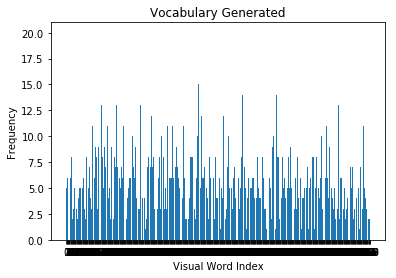

Temps d execution après plot BOV : 84.4869999886 secondes ---
25.055357142857144
14031.0
0.0017857142857142859
--------------------------------- sop test cluster 560 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 585 ---------------------------------
Temps d execution apres Clustering : 85.1119999886 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 85.120000124 secondes ---
Plotting histogram


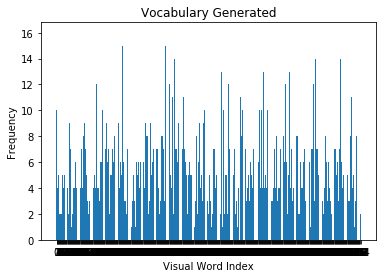

Temps d execution après plot BOV : 104.457000017 secondes ---
23.984615384615385
14031.0
0.0017094017094017094
--------------------------------- sop test cluster 585 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 610 ---------------------------------
Temps d execution apres Clustering : 137.605000019 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 137.618000031 secondes ---
Plotting histogram


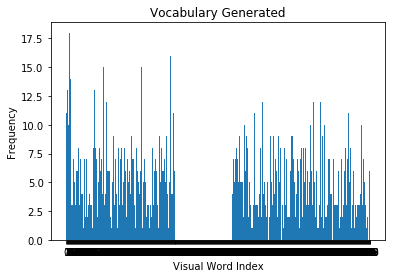

Temps d execution après plot BOV : 146.549999952 secondes ---
23.001639344262294
14031.0
0.001639344262295082
--------------------------------- sop test cluster 610 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 635 ---------------------------------
Temps d execution apres Clustering : 114.343000174 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 114.351999998 secondes ---
Plotting histogram


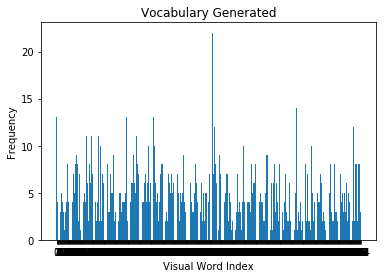

Temps d execution après plot BOV : 124.820000172 secondes ---
22.096062992125983
14031.0
0.0015748031496062992
--------------------------------- sop test cluster 635 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 660 ---------------------------------
Temps d execution apres Clustering : 110.151000023 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 110.161000013 secondes ---
Plotting histogram


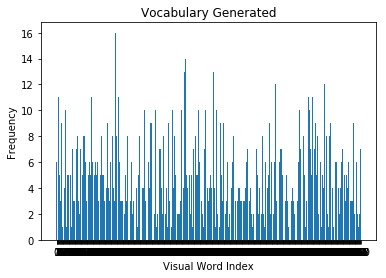

Temps d execution après plot BOV : 123.036000013 secondes ---
21.259090909090908
14031.0
0.0015151515151515152
--------------------------------- sop test cluster 660 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 685 ---------------------------------
Temps d execution apres Clustering : 117.144999981 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 117.154999971 secondes ---
Plotting histogram


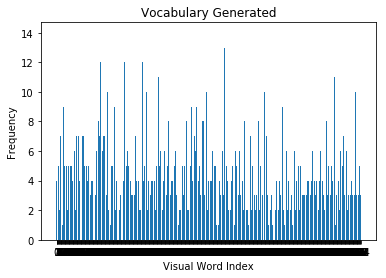

Temps d execution après plot BOV : 132.621999979 secondes ---
20.483211678832117
14031.0
0.00145985401459854
--------------------------------- sop test cluster 685 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 710 ---------------------------------
Temps d execution apres Clustering : 124.437000036 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 124.447000027 secondes ---
Plotting histogram


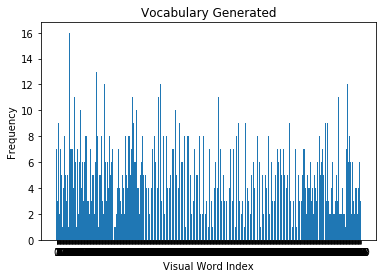

Temps d execution après plot BOV : 136.167999983 secondes ---
19.761971830985914
14031.0
0.001408450704225352
--------------------------------- sop test cluster 710 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 735 ---------------------------------
Temps d execution apres Clustering : 156.974999905 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 156.990999937 secondes ---
Plotting histogram


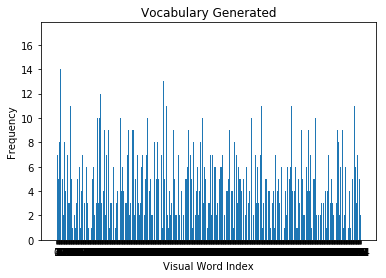

Temps d execution après plot BOV : 173.758999825 secondes ---
19.089795918367347
14031.0
0.0013605442176870747
--------------------------------- sop test cluster 735 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 760 ---------------------------------
Temps d execution apres Clustering : 177.577000141 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 177.604000092 secondes ---
Plotting histogram


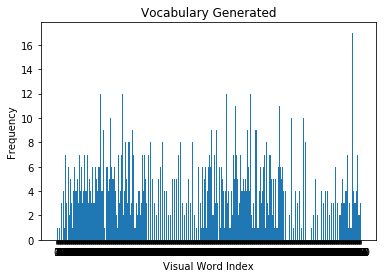

Temps d execution après plot BOV : 202.368000031 secondes ---
18.46184210526316
14031.0
0.0013157894736842105
--------------------------------- sop test cluster 760 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 785 ---------------------------------
Temps d execution apres Clustering : 146.441999912 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 146.451999903 secondes ---
Plotting histogram


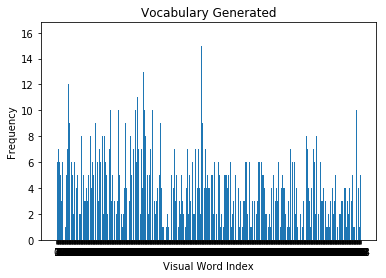

Temps d execution après plot BOV : 156.769999981 secondes ---
17.87388535031847
14031.0
0.0012738853503184713
--------------------------------- sop test cluster 785 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 810 ---------------------------------
Temps d execution apres Clustering : 141.73300004 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 141.751999855 secondes ---
Plotting histogram


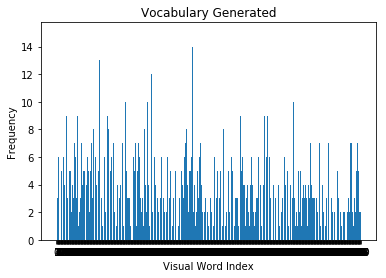

Temps d execution après plot BOV : 161.86500001 secondes ---
17.322222222222223
14031.0
0.0012345679012345679
--------------------------------- sop test cluster 810 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 835 ---------------------------------
Temps d execution apres Clustering : 157.304000139 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 157.31400013 secondes ---
Plotting histogram


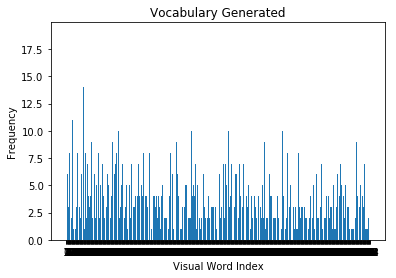

Temps d execution après plot BOV : 166.933000088 secondes ---
16.803592814371257
14031.0
0.0011976047904191617
--------------------------------- sop test cluster 835 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 860 ---------------------------------
Temps d execution apres Clustering : 152.913000107 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 152.927999973 secondes ---
Plotting histogram


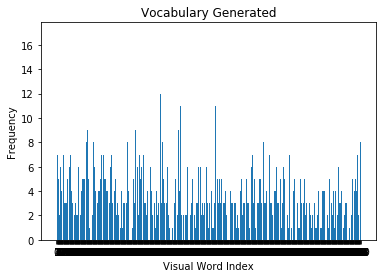

Temps d execution après plot BOV : 164.694000006 secondes ---
16.315116279069766
14031.0
0.0011627906976744186
--------------------------------- sop test cluster 860 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 885 ---------------------------------
Temps d execution apres Clustering : 137.299999952 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 137.312000036 secondes ---
Plotting histogram


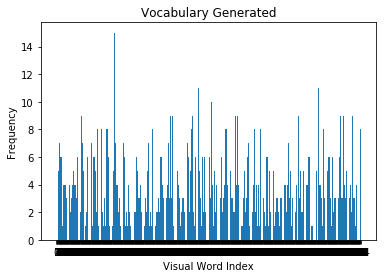

Temps d execution après plot BOV : 149.450000048 secondes ---
15.854237288135593
14031.0
0.0011299435028248588
--------------------------------- sop test cluster 885 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 910 ---------------------------------
Temps d execution apres Clustering : 143.09100008 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 143.102999926 secondes ---
Plotting histogram


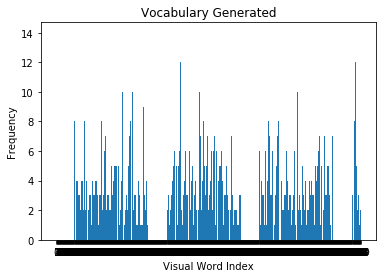

Temps d execution après plot BOV : 155.776000023 secondes ---
15.418681318681319
14031.0
0.001098901098901099
--------------------------------- sop test cluster 910 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 935 ---------------------------------
Temps d execution apres Clustering : 150.373000145 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 150.386000156 secondes ---
Plotting histogram


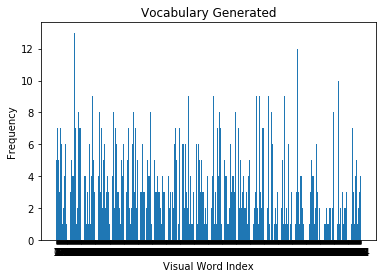

Temps d execution après plot BOV : 162.592000008 secondes ---
15.006417112299465
14031.0
0.0010695187165775401
--------------------------------- sop test cluster 935 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 960 ---------------------------------
Temps d execution apres Clustering : 179.0 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 179.010999918 secondes ---
Plotting histogram


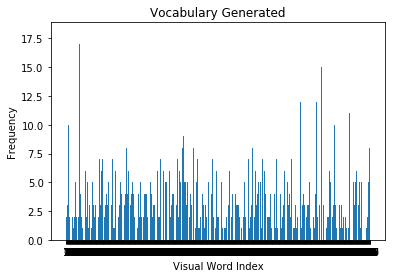

Temps d execution après plot BOV : 197.447999954 secondes ---
14.615625
14031.0
0.0010416666666666667
--------------------------------- sop test cluster 960 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 985 ---------------------------------
Temps d execution apres Clustering : 169.568000078 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 169.577000141 secondes ---
Plotting histogram


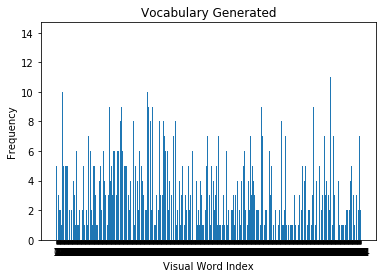

Temps d execution après plot BOV : 182.880000114 secondes ---
14.244670050761421
14031.0
0.0010152284263959391
--------------------------------- sop test cluster 985 ---------------------------------


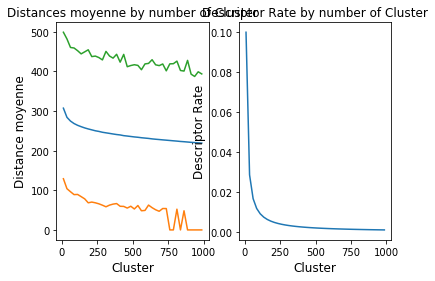

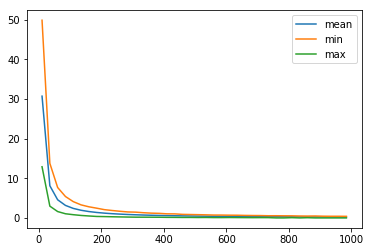

Temps d execution optimisation : 4092.13899994 secondes ---


In [4]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=100,#40, 
        number_images=2,#20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 1000
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 100
Max Number of picture by directory : 10
Generator : ORB
Number of feature : 75
Minimum feature size  75
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-r

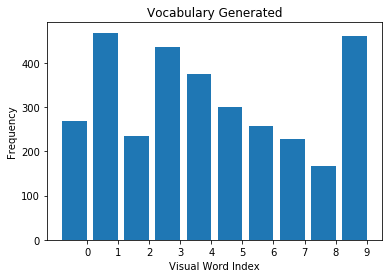

Temps d execution après plot BOV : 24.4119999409 secondes ---
7062.5
70625.0
0.1
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 93.4040000439 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 93.4200000763 secondes ---
Plotting histogram


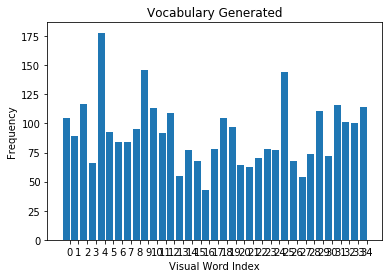

Temps d execution après plot BOV : 93.7019999027 secondes ---
2017.857142857143
70625.0
0.02857142857142857
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 159.117000103 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 159.117000103 secondes ---
Plotting histogram


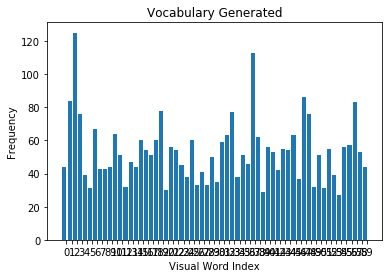

Temps d execution après plot BOV : 159.588000059 secondes ---
1177.0833333333333
70625.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 221.64199996 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 221.64199996 secondes ---
Plotting histogram


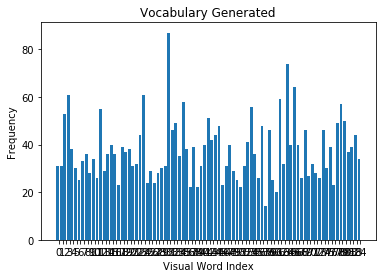

Temps d execution après plot BOV : 222.250999928 secondes ---
830.8823529411765
70625.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------
Temps d execution apres Clustering : 318.855000019 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 318.855000019 secondes ---
Plotting histogram


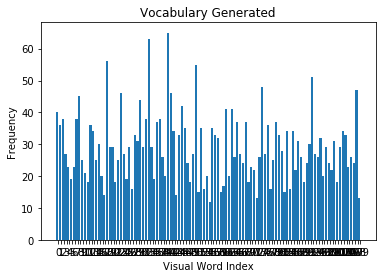

Temps d execution après plot BOV : 319.625 secondes ---
642.0454545454545
70625.0
0.00909090909090909
--------------------------------- sop test cluster 110 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 135 ---------------------------------
Temps d execution apres Clustering : 341.029999971 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 341.029999971 secondes ---
Plotting histogram


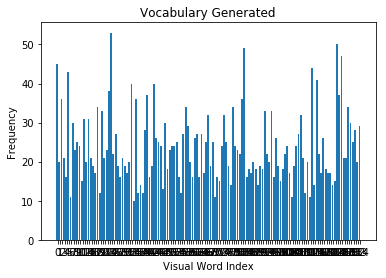

Temps d execution après plot BOV : 341.952000141 secondes ---
523.1481481481482
70625.0
0.007407407407407408
--------------------------------- sop test cluster 135 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 160 ---------------------------------
Temps d execution apres Clustering : 325.180999994 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 325.180999994 secondes ---
Plotting histogram


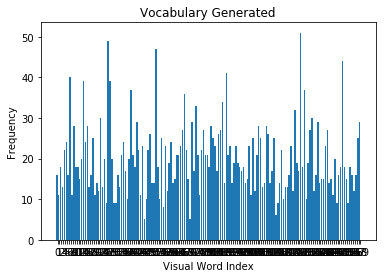

Temps d execution après plot BOV : 326.322000027 secondes ---
441.40625
70625.0
0.00625
--------------------------------- sop test cluster 160 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 185 ---------------------------------
Temps d execution apres Clustering : 441.795000076 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 441.795000076 secondes ---
Plotting histogram


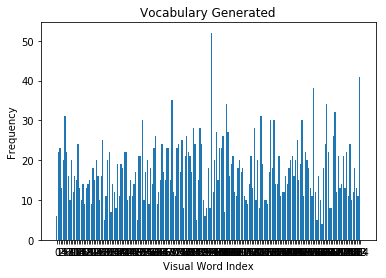

Temps d execution après plot BOV : 443.029000044 secondes ---
381.7567567567568
70625.0
0.005405405405405406
--------------------------------- sop test cluster 185 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 210 ---------------------------------
Temps d execution apres Clustering : 426.042000055 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 426.05700016 secondes ---
Plotting histogram


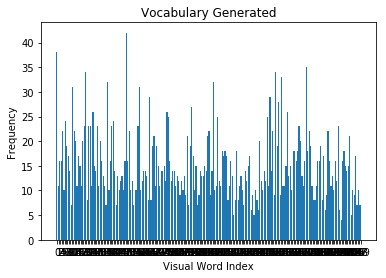

Temps d execution après plot BOV : 427.518000126 secondes ---
336.3095238095238
70625.0
0.0047619047619047615
--------------------------------- sop test cluster 210 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 235 ---------------------------------
Temps d execution apres Clustering : 469.536000013 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 469.536000013 secondes ---
Plotting histogram


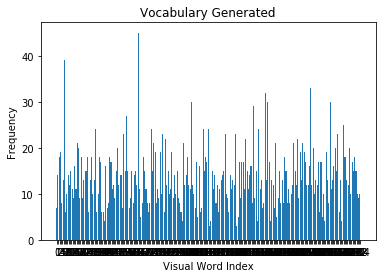

Temps d execution après plot BOV : 471.082999945 secondes ---
300.531914893617
70625.0
0.00425531914893617
--------------------------------- sop test cluster 235 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 260 ---------------------------------
Temps d execution apres Clustering : 521.73300004 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 521.73300004 secondes ---
Plotting histogram


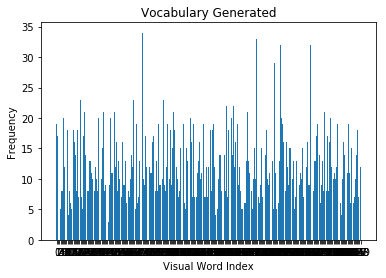

Temps d execution après plot BOV : 523.515000105 secondes ---
271.63461538461536
70625.0
0.003846153846153846
--------------------------------- sop test cluster 260 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 285 ---------------------------------
Temps d execution apres Clustering : 514.493000031 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 514.493000031 secondes ---
Plotting histogram


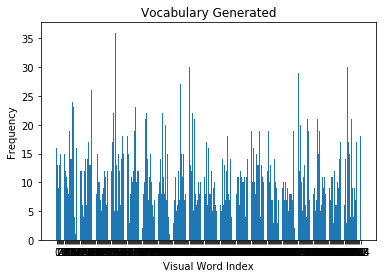

Temps d execution après plot BOV : 516.323999882 secondes ---
247.80701754385964
70625.0
0.0035087719298245615
--------------------------------- sop test cluster 285 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 310 ---------------------------------
Temps d execution apres Clustering : 534.082000017 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 534.082000017 secondes ---
Plotting histogram


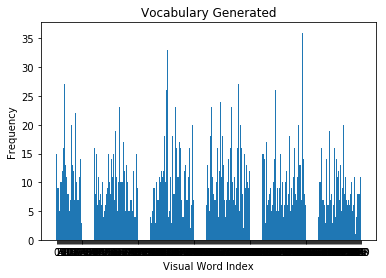

Temps d execution après plot BOV : 536.164000034 secondes ---
227.82258064516128
70625.0
0.0032258064516129032
--------------------------------- sop test cluster 310 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 335 ---------------------------------
Temps d execution apres Clustering : 529.82400012 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 529.82400012 secondes ---
Plotting histogram


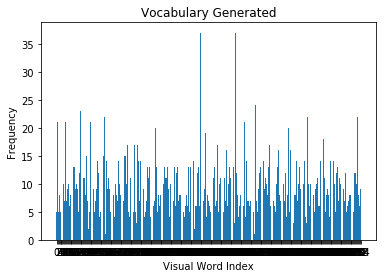

Temps d execution après plot BOV : 532.003000021 secondes ---
210.82089552238807
70625.0
0.0029850746268656717
--------------------------------- sop test cluster 335 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 360 ---------------------------------
Temps d execution apres Clustering : 568.302000046 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 568.302000046 secondes ---
Plotting histogram


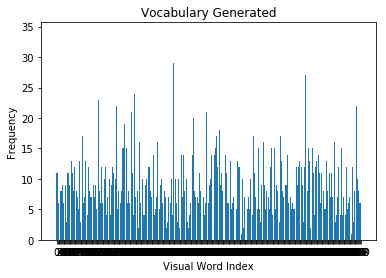

Temps d execution après plot BOV : 570.691999912 secondes ---
196.18055555555554
70625.0
0.0027777777777777775
--------------------------------- sop test cluster 360 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 385 ---------------------------------
Temps d execution apres Clustering : 590.461999893 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 590.461999893 secondes ---
Plotting histogram


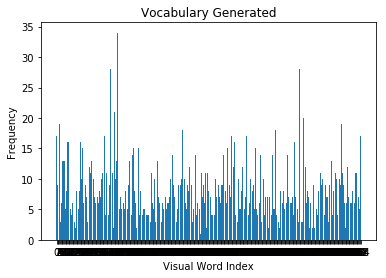

Temps d execution après plot BOV : 593.007999897 secondes ---
183.44155844155844
70625.0
0.0025974025974025974
--------------------------------- sop test cluster 385 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 410 ---------------------------------
Temps d execution apres Clustering : 666.632999897 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 666.648999929 secondes ---
Plotting histogram


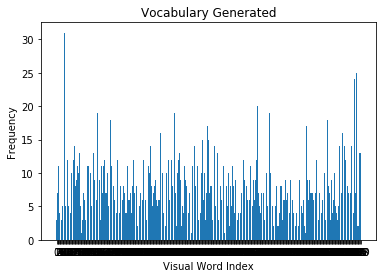

Temps d execution après plot BOV : 669.369999886 secondes ---
172.2560975609756
70625.0
0.0024390243902439024
--------------------------------- sop test cluster 410 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 435 ---------------------------------
Temps d execution apres Clustering : 669.866999865 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 669.866999865 secondes ---
Plotting histogram


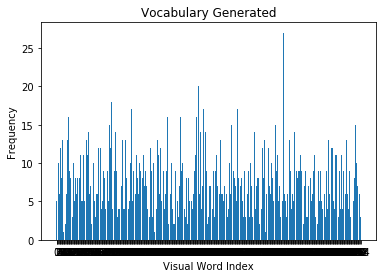

Temps d execution après plot BOV : 672.714999914 secondes ---
162.35632183908046
70625.0
0.0022988505747126436
--------------------------------- sop test cluster 435 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 460 ---------------------------------
Temps d execution apres Clustering : 639.312999964 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 639.328000069 secondes ---
Plotting histogram


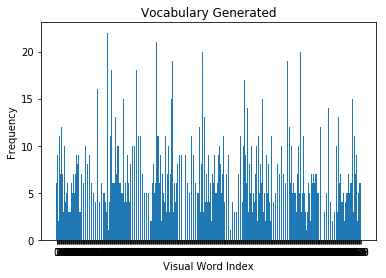

Temps d execution après plot BOV : 642.253999949 secondes ---
153.5326086956522
70625.0
0.002173913043478261
--------------------------------- sop test cluster 460 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 485 ---------------------------------
Temps d execution apres Clustering : 736.203999996 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 736.203999996 secondes ---
Plotting histogram


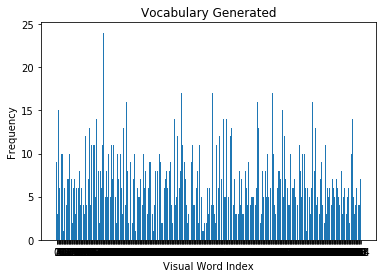

Temps d execution après plot BOV : 739.394999981 secondes ---
145.61855670103094
70625.0
0.002061855670103093
--------------------------------- sop test cluster 485 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 510 ---------------------------------
Temps d execution apres Clustering : 719.80099988 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 719.816999912 secondes ---
Plotting histogram


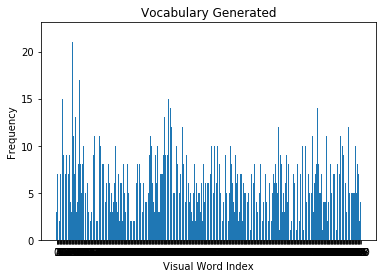

Temps d execution après plot BOV : 723.116999865 secondes ---
138.48039215686273
70625.0
0.00196078431372549
--------------------------------- sop test cluster 510 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 535 ---------------------------------
Temps d execution apres Clustering : 655.463000059 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 655.480000019 secondes ---
Plotting histogram


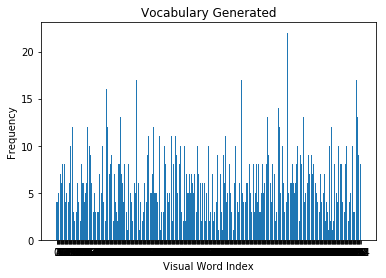

Temps d execution après plot BOV : 658.921000004 secondes ---
132.00934579439252
70625.0
0.0018691588785046728
--------------------------------- sop test cluster 535 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 560 ---------------------------------
Temps d execution apres Clustering : 718.25 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 718.25 secondes ---
Plotting histogram


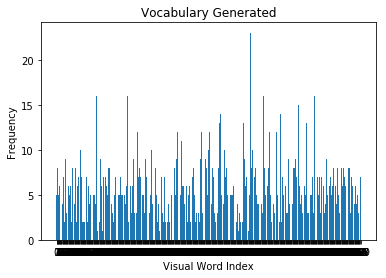

Temps d execution après plot BOV : 721.88499999 secondes ---
126.11607142857143
70625.0
0.0017857142857142857
--------------------------------- sop test cluster 560 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 585 ---------------------------------
Temps d execution apres Clustering : 771.121999979 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 771.121999979 secondes ---
Plotting histogram


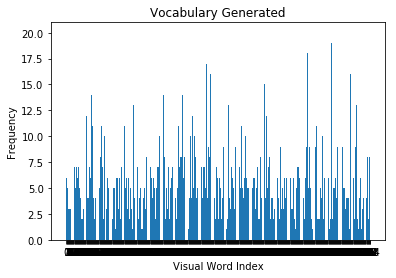

Temps d execution après plot BOV : 774.983999968 secondes ---
120.72649572649573
70625.0
0.0017094017094017094
--------------------------------- sop test cluster 585 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 610 ---------------------------------
Temps d execution apres Clustering : 745.14199996 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 745.14199996 secondes ---
Plotting histogram


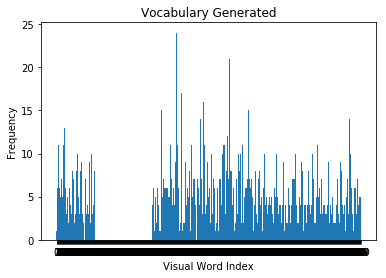

Temps d execution après plot BOV : 749.246000051 secondes ---
115.77868852459017
70625.0
0.001639344262295082
--------------------------------- sop test cluster 610 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 635 ---------------------------------
Temps d execution apres Clustering : 817.25 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 817.266000032 secondes ---
Plotting histogram


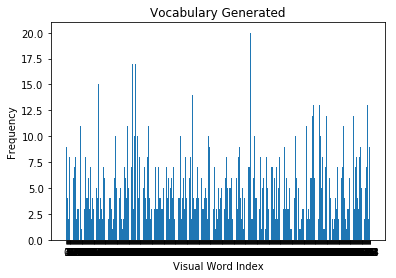

Temps d execution après plot BOV : 821.354000092 secondes ---
111.22047244094489
70625.0
0.0015748031496062994
--------------------------------- sop test cluster 635 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 660 ---------------------------------
Temps d execution apres Clustering : 841.629999876 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 841.629999876 secondes ---
Plotting histogram


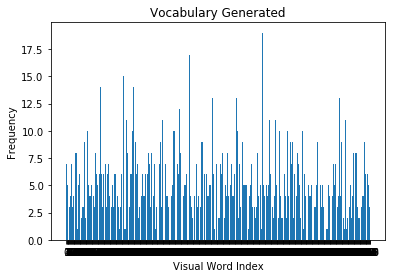

Temps d execution après plot BOV : 845.917999983 secondes ---
107.00757575757575
70625.0
0.0015151515151515152
--------------------------------- sop test cluster 660 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 685 ---------------------------------
Temps d execution apres Clustering : 804.305999994 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 804.320999861 secondes ---
Plotting histogram


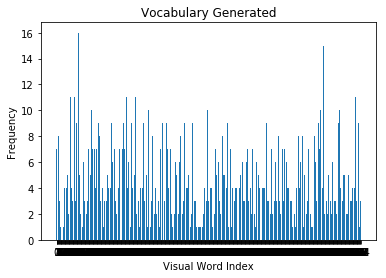

Temps d execution après plot BOV : 808.743999958 secondes ---
103.10218978102189
70625.0
0.00145985401459854
--------------------------------- sop test cluster 685 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 710 ---------------------------------
Temps d execution apres Clustering : 898.328999996 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 898.328999996 secondes ---
Plotting histogram


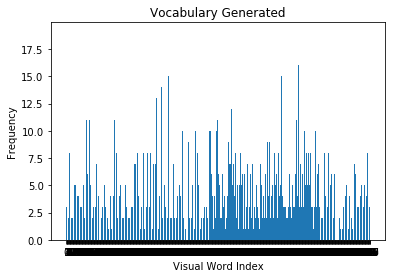

Temps d execution après plot BOV : 902.960000038 secondes ---
99.47183098591549
70625.0
0.001408450704225352
--------------------------------- sop test cluster 710 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 735 ---------------------------------
Temps d execution apres Clustering : 812.520999908 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 812.536000013 secondes ---
Plotting histogram


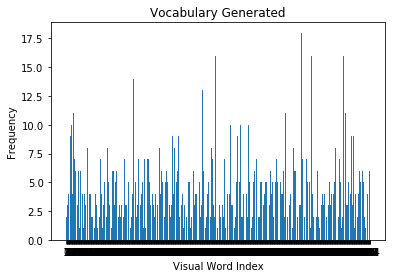

Temps d execution après plot BOV : 817.405999899 secondes ---
96.08843537414965
70625.0
0.0013605442176870747
--------------------------------- sop test cluster 735 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 760 ---------------------------------
Temps d execution apres Clustering : 879.828000069 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 879.844000101 secondes ---
Plotting histogram


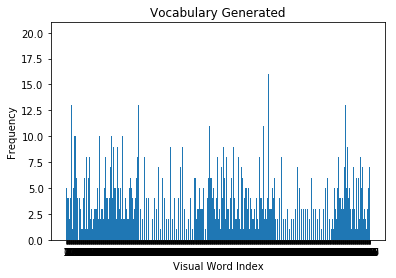

Temps d execution après plot BOV : 884.83100009 secondes ---
92.92763157894737
70625.0
0.0013157894736842105
--------------------------------- sop test cluster 760 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 785 ---------------------------------
Temps d execution apres Clustering : 863.609000206 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 863.628000021 secondes ---
Plotting histogram


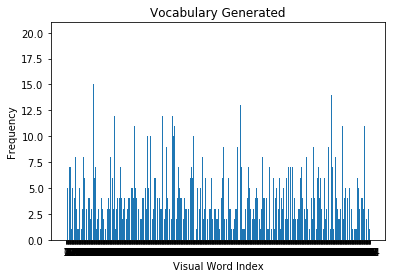

Temps d execution après plot BOV : 868.661000013 secondes ---
89.96815286624204
70625.0
0.0012738853503184713
--------------------------------- sop test cluster 785 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 810 ---------------------------------
Temps d execution apres Clustering : 874.623000145 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 874.623000145 secondes ---
Plotting histogram


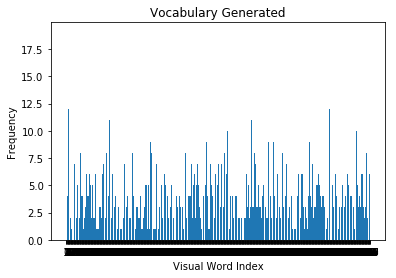

Temps d execution après plot BOV : 879.976999998 secondes ---
87.19135802469135
70625.0
0.0012345679012345679
--------------------------------- sop test cluster 810 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 835 ---------------------------------
Temps d execution apres Clustering : 1020.37100005 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1020.37100005 secondes ---
Plotting histogram


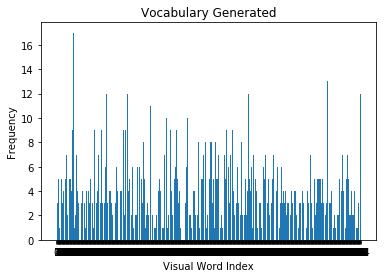

Temps d execution après plot BOV : 1025.75500011 secondes ---
84.58083832335329
70625.0
0.0011976047904191617
--------------------------------- sop test cluster 835 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 860 ---------------------------------
Temps d execution apres Clustering : 1010.68099999 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1010.68099999 secondes ---
Plotting histogram


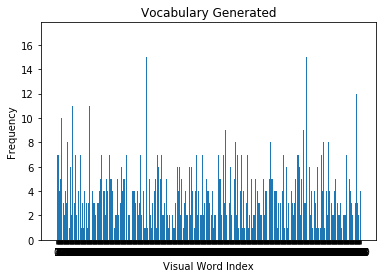

Temps d execution après plot BOV : 1016.40499997 secondes ---
82.12209302325581
70625.0
0.0011627906976744186
--------------------------------- sop test cluster 860 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 885 ---------------------------------
Temps d execution apres Clustering : 1012.648 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1012.66300011 secondes ---
Plotting histogram


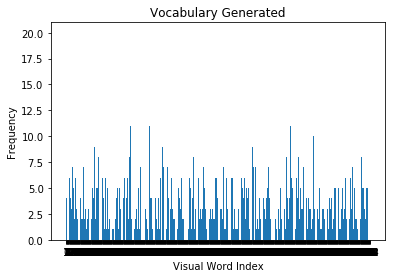

Temps d execution après plot BOV : 1018.38900018 secondes ---
79.80225988700565
70625.0
0.0011299435028248588
--------------------------------- sop test cluster 885 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 910 ---------------------------------
Temps d execution apres Clustering : 983.49000001 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 983.504999876 secondes ---
Plotting histogram


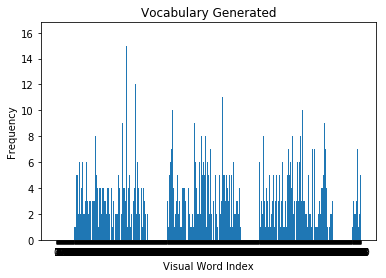

Temps d execution après plot BOV : 989.375999928 secondes ---
77.60989010989012
70625.0
0.001098901098901099
--------------------------------- sop test cluster 910 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 935 ---------------------------------
Temps d execution apres Clustering : 929.643999815 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 929.65899992 secondes ---
Plotting histogram


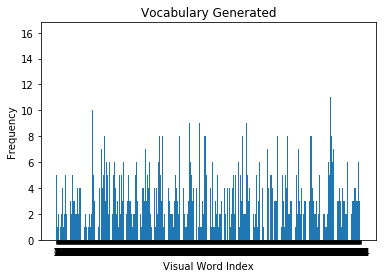

Temps d execution après plot BOV : 935.678999901 secondes ---
75.53475935828877
70625.0
0.0010695187165775401
--------------------------------- sop test cluster 935 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 960 ---------------------------------
Temps d execution apres Clustering : 32704.7030001 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 32704.733 secondes ---
Plotting histogram


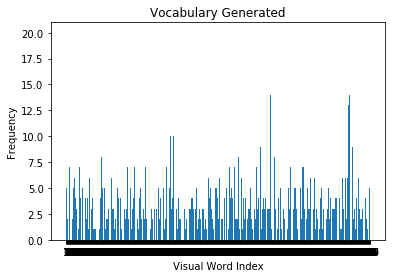

Temps d execution après plot BOV : 32717.1430001 secondes ---
73.56770833333333
70625.0
0.0010416666666666667
--------------------------------- sop test cluster 960 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 985 ---------------------------------
Temps d execution apres Clustering : 9068.78399992 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 9068.83200002 secondes ---
Plotting histogram


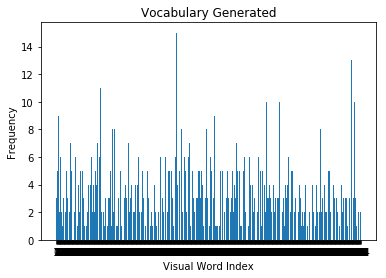

Temps d execution après plot BOV : 9082.29699993 secondes ---
71.7005076142132
70625.0
0.0010152284263959391
--------------------------------- sop test cluster 985 ---------------------------------


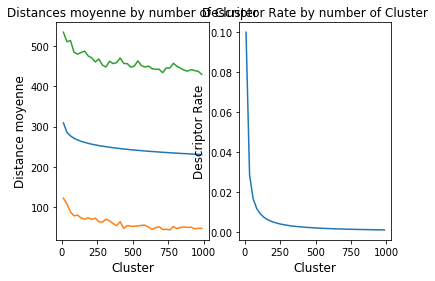

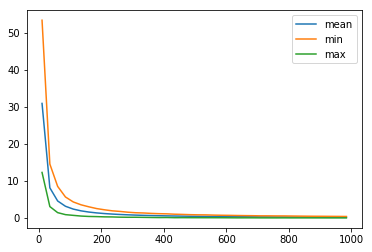

Temps d execution optimisation : 66100.609 secondes ---


In [5]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=100, 
        number_images=10,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 1000
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 100
Max Number of picture by directory : 10
Generator : ORB
Number of feature : 75
Minimum feature size  75
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-r

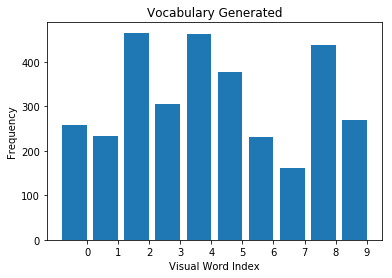

Temps d execution après plot BOV : 22.2130000591 secondes ---
7062.5
70625.0
0.1
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 95.3339998722 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 95.3339998722 secondes ---
Plotting histogram


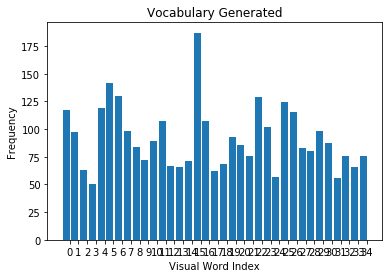

Temps d execution après plot BOV : 95.5849997997 secondes ---
2017.857142857143
70625.0
0.02857142857142857
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 159.42200017 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 159.437999964 secondes ---
Plotting histogram


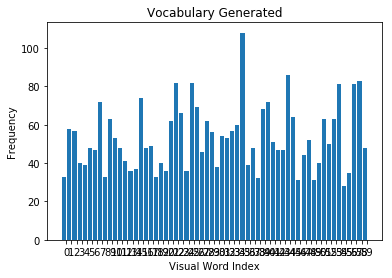

Temps d execution après plot BOV : 159.904999971 secondes ---
1177.0833333333333
70625.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 263.196999788 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 263.196999788 secondes ---
Plotting histogram


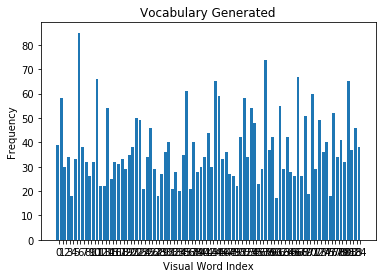

Temps d execution après plot BOV : 263.965999842 secondes ---
830.8823529411765
70625.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------
Temps d execution apres Clustering : 341.146000147 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 341.146000147 secondes ---
Plotting histogram


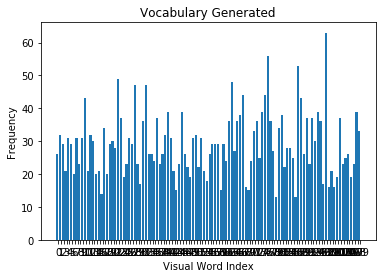

Temps d execution après plot BOV : 341.930999994 secondes ---
642.0454545454545
70625.0
0.00909090909090909
--------------------------------- sop test cluster 110 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 135 ---------------------------------
Temps d execution apres Clustering : 377.52699995 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 377.542999983 secondes ---
Plotting histogram


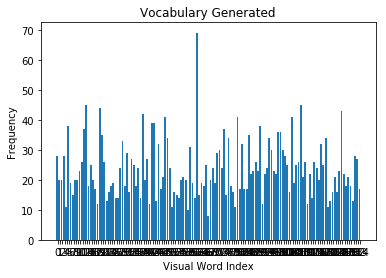

Temps d execution après plot BOV : 378.697000027 secondes ---
523.1481481481482
70625.0
0.007407407407407408
--------------------------------- sop test cluster 135 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 160 ---------------------------------
Temps d execution apres Clustering : 412.32400012 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 412.32400012 secondes ---
Plotting histogram


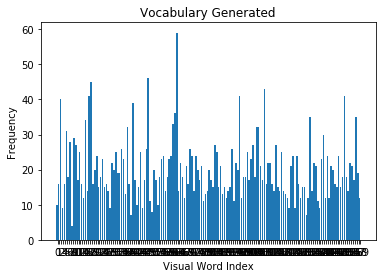

Temps d execution après plot BOV : 413.64199996 secondes ---
441.40625
70625.0
0.00625
--------------------------------- sop test cluster 160 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 185 ---------------------------------
Temps d execution apres Clustering : 401.374000072 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 401.390000105 secondes ---
Plotting histogram


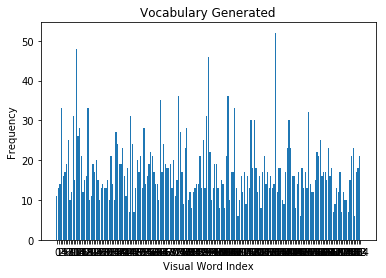

Temps d execution après plot BOV : 402.759000063 secondes ---
381.7567567567568
70625.0
0.005405405405405406
--------------------------------- sop test cluster 185 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 210 ---------------------------------
Temps d execution apres Clustering : 454.355000019 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 454.355000019 secondes ---
Plotting histogram


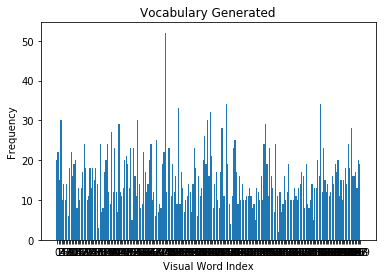

Temps d execution après plot BOV : 455.825999975 secondes ---
336.3095238095238
70625.0
0.0047619047619047615
--------------------------------- sop test cluster 210 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 235 ---------------------------------
Temps d execution apres Clustering : 446.404000044 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 446.404000044 secondes ---
Plotting histogram


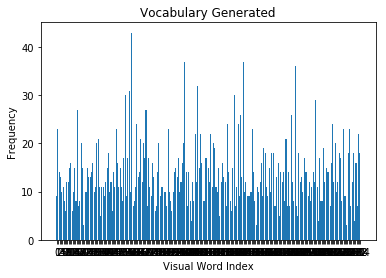

Temps d execution après plot BOV : 448.193000078 secondes ---
300.531914893617
70625.0
0.00425531914893617
--------------------------------- sop test cluster 235 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 260 ---------------------------------
Temps d execution apres Clustering : 458.73300004 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 458.749000072 secondes ---
Plotting histogram


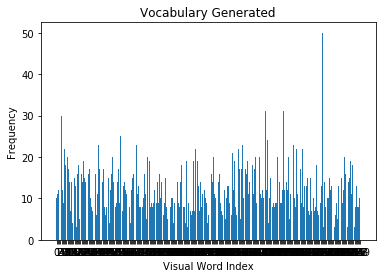

Temps d execution après plot BOV : 460.493000031 secondes ---
271.63461538461536
70625.0
0.003846153846153846
--------------------------------- sop test cluster 260 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 285 ---------------------------------
Temps d execution apres Clustering : 551.921999931 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 551.937999964 secondes ---
Plotting histogram


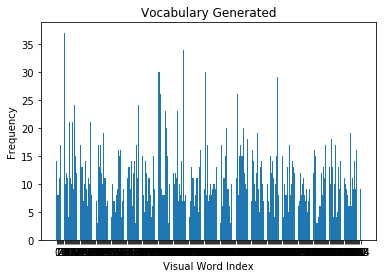

Temps d execution après plot BOV : 553.926999807 secondes ---
247.80701754385964
70625.0
0.0035087719298245615
--------------------------------- sop test cluster 285 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 310 ---------------------------------
Temps d execution apres Clustering : 553.048000097 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 553.058000088 secondes ---
Plotting histogram


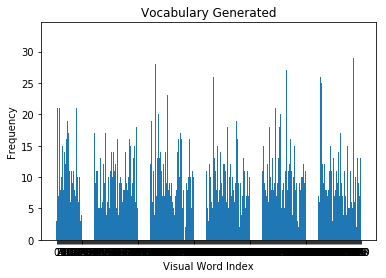

Temps d execution après plot BOV : 556.121999979 secondes ---
227.82258064516128
70625.0
0.0032258064516129032
--------------------------------- sop test cluster 310 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 335 ---------------------------------
Temps d execution apres Clustering : 595.207000017 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 595.213999987 secondes ---
Plotting histogram


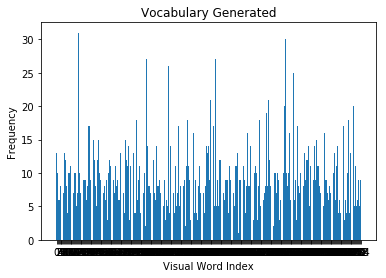

Temps d execution après plot BOV : 597.642999887 secondes ---
210.82089552238807
70625.0
0.0029850746268656717
--------------------------------- sop test cluster 335 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 360 ---------------------------------
Temps d execution apres Clustering : 662.09100008 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 662.09100008 secondes ---
Plotting histogram


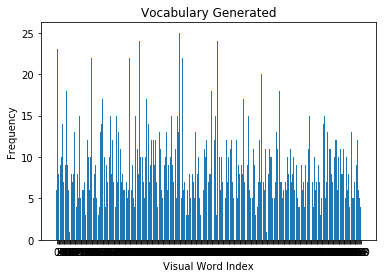

Temps d execution après plot BOV : 664.942000151 secondes ---
196.18055555555554
70625.0
0.0027777777777777775
--------------------------------- sop test cluster 360 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 385 ---------------------------------
Temps d execution apres Clustering : 629.305000067 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 629.305000067 secondes ---
Plotting histogram


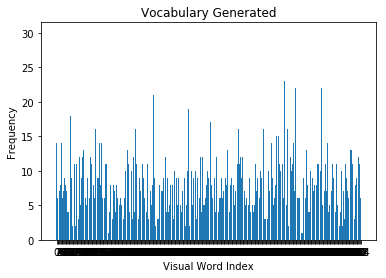

Temps d execution après plot BOV : 632.198000193 secondes ---
183.44155844155844
70625.0
0.0025974025974025974
--------------------------------- sop test cluster 385 ---------------------------------


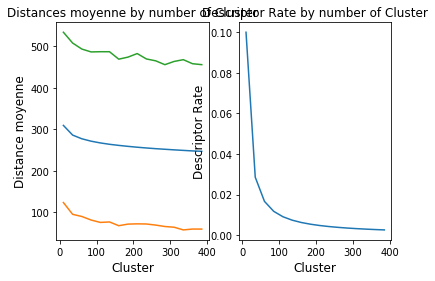

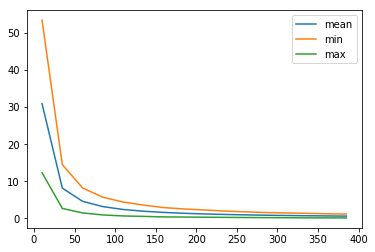

Temps d execution optimisation : 6458.85500002 secondes ---


In [3]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=100, 
        number_images=10,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 400
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 0
Max Number of picture by directory : 10
Generator : ORB
Number of feature : 75
Minimum feature size  75
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-red

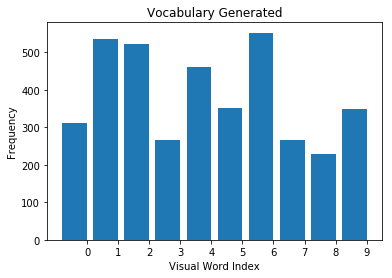

Temps d execution après plot BOV : 26.4099998474 secondes ---
8451.3
84513.0
0.09999999999999999
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 138.506000042 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 138.512000084 secondes ---
Plotting histogram


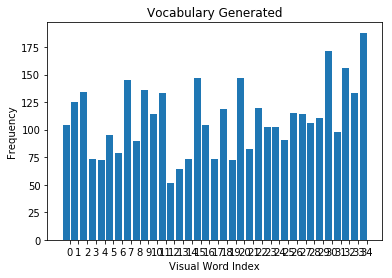

Temps d execution après plot BOV : 138.789000034 secondes ---
2414.657142857143
84513.0
0.02857142857142857
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 252.540999889 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 252.540999889 secondes ---
Plotting histogram


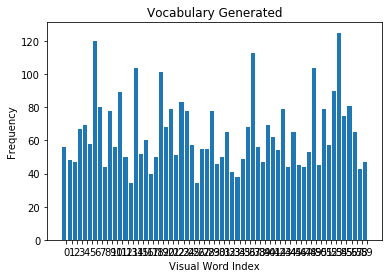

Temps d execution après plot BOV : 253.034999847 secondes ---
1408.55
84513.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 336.437999964 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 336.437999964 secondes ---
Plotting histogram


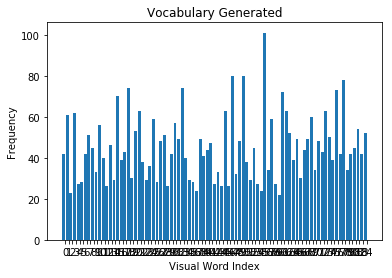

Temps d execution après plot BOV : 337.062000036 secondes ---
994.2705882352941
84513.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------
Temps d execution apres Clustering : 417.322999954 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 417.328999996 secondes ---
Plotting histogram


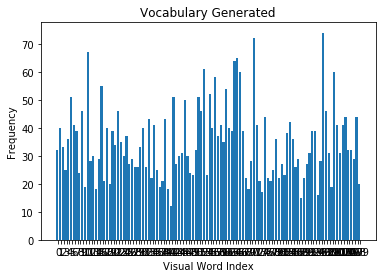

Temps d execution après plot BOV : 418.279000044 secondes ---
768.3
84513.0
0.00909090909090909
--------------------------------- sop test cluster 110 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 135 ---------------------------------
Temps d execution apres Clustering : 479.22300005 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 479.239000082 secondes ---
Plotting histogram


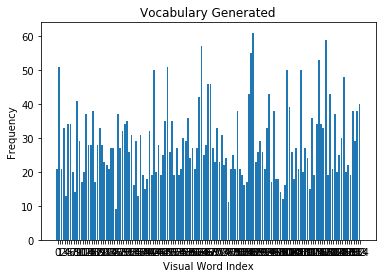

Temps d execution après plot BOV : 480.177000046 secondes ---
626.0222222222222
84513.0
0.007407407407407408
--------------------------------- sop test cluster 135 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 160 ---------------------------------
Temps d execution apres Clustering : 471.392999887 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 471.392999887 secondes ---
Plotting histogram


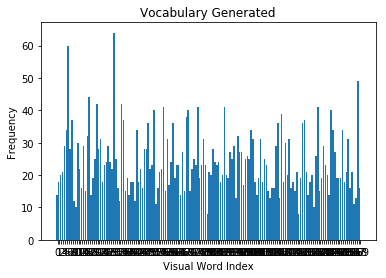

Temps d execution après plot BOV : 472.457000017 secondes ---
528.20625
84513.0
0.0062499999999999995
--------------------------------- sop test cluster 160 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 185 ---------------------------------
Temps d execution apres Clustering : 530.981999874 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 530.996999979 secondes ---
Plotting histogram


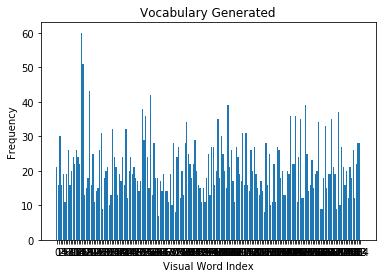

Temps d execution après plot BOV : 532.313999891 secondes ---
456.82702702702704
84513.0
0.005405405405405406
--------------------------------- sop test cluster 185 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 210 ---------------------------------
Temps d execution apres Clustering : 573.207999945 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 573.207999945 secondes ---
Plotting histogram


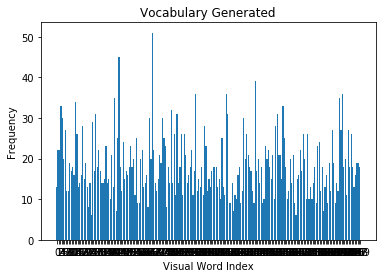

Temps d execution après plot BOV : 574.61500001 secondes ---
402.4428571428571
84513.0
0.0047619047619047615
--------------------------------- sop test cluster 210 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 235 ---------------------------------
Temps d execution apres Clustering : 622.777000189 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 622.777000189 secondes ---
Plotting histogram


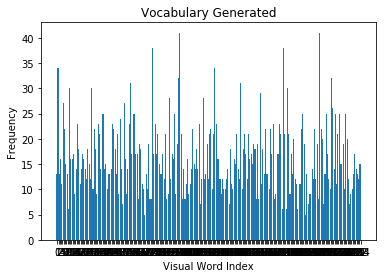

Temps d execution après plot BOV : 624.388000011 secondes ---
359.62978723404257
84513.0
0.00425531914893617
--------------------------------- sop test cluster 235 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 260 ---------------------------------
Temps d execution apres Clustering : 652.320000172 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 652.336000204 secondes ---
Plotting histogram


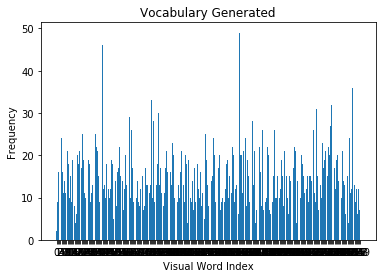

Temps d execution après plot BOV : 654.011000156 secondes ---
325.05
84513.0
0.0038461538461538464
--------------------------------- sop test cluster 260 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 285 ---------------------------------
Temps d execution apres Clustering : 659.606999874 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 659.606999874 secondes ---
Plotting histogram


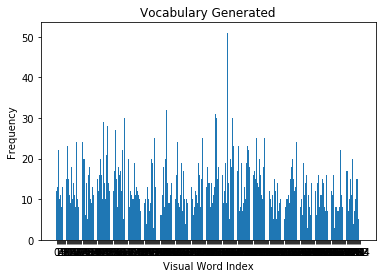

Temps d execution après plot BOV : 661.559999943 secondes ---
296.53684210526313
84513.0
0.003508771929824561
--------------------------------- sop test cluster 285 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 310 ---------------------------------
Temps d execution apres Clustering : 712.934000015 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 712.950000048 secondes ---
Plotting histogram


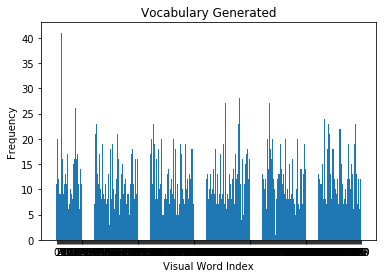

Temps d execution après plot BOV : 714.964999914 secondes ---
272.6225806451613
84513.0
0.0032258064516129032
--------------------------------- sop test cluster 310 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 335 ---------------------------------
Temps d execution apres Clustering : 621.856999874 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 621.856999874 secondes ---
Plotting histogram


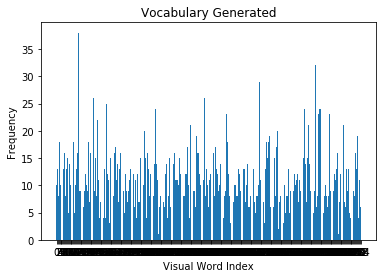

Temps d execution après plot BOV : 624.14199996 secondes ---
252.2776119402985
84513.0
0.0029850746268656717
--------------------------------- sop test cluster 335 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 360 ---------------------------------
Temps d execution apres Clustering : 734.527999878 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 734.542999983 secondes ---
Plotting histogram


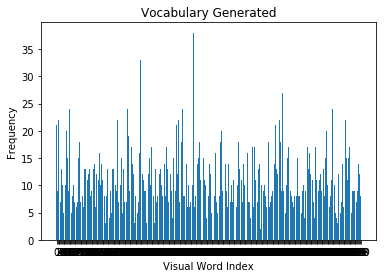

Temps d execution après plot BOV : 736.951999903 secondes ---
234.75833333333333
84513.0
0.002777777777777778
--------------------------------- sop test cluster 360 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 385 ---------------------------------
Temps d execution apres Clustering : 746.259000063 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 746.259000063 secondes ---
Plotting histogram


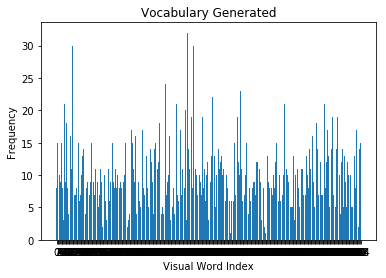

Temps d execution après plot BOV : 748.730999947 secondes ---
219.5142857142857
84513.0
0.0025974025974025974
--------------------------------- sop test cluster 385 ---------------------------------


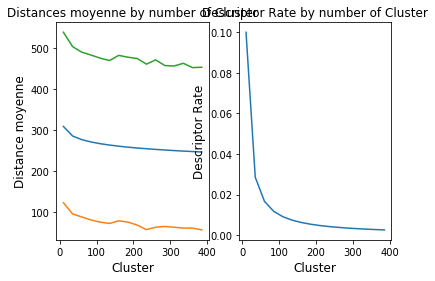

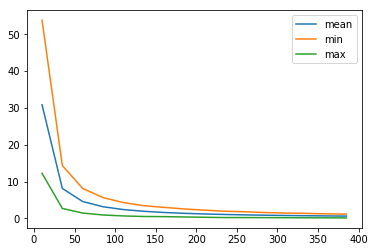

Temps d execution optimisation : 8009.93499994 secondes ---


In [4]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=0, 
        number_images=10,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 400
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 0
Max Number of picture by directory : 50
Generator : ORB
Number of feature : 60
Minimum feature size  60
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-red

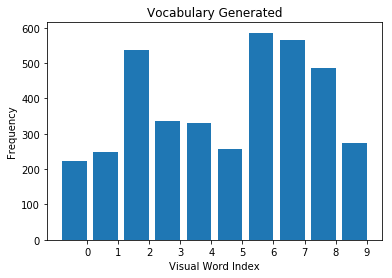

Temps d execution après plot BOV : 138.694999933 secondes ---
34143.9
341439.0
0.1
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 825.409000158 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 825.424999952 secondes ---
Plotting histogram


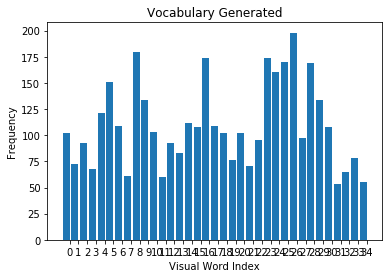

Temps d execution après plot BOV : 825.960000038 secondes ---
9755.4
341439.0
0.02857142857142857
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 1622.92000008 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1622.96700001 secondes ---
Plotting histogram


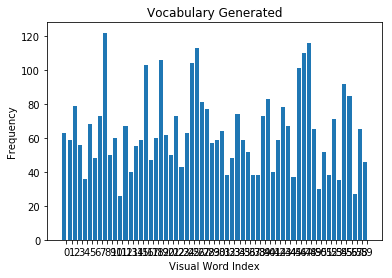

Temps d execution après plot BOV : 1624.15700006 secondes ---
5690.65
341439.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 1742.82399988 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1742.8349998 secondes ---
Plotting histogram


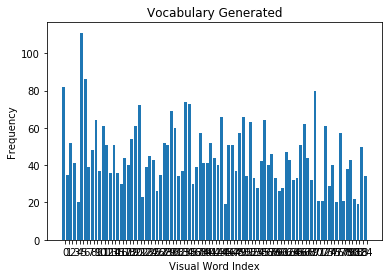

Temps d execution après plot BOV : 1744.11199999 secondes ---
4016.929411764706
341439.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------
Temps d execution apres Clustering : 2131.24199986 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 2131.2579999 secondes ---
Plotting histogram


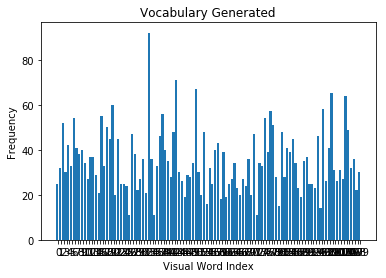

Temps d execution après plot BOV : 2132.05699992 secondes ---
3103.990909090909
341439.0
0.00909090909090909
--------------------------------- sop test cluster 110 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 135 ---------------------------------
Temps d execution apres Clustering : 2555.58399987 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 2555.58399987 secondes ---
Plotting histogram


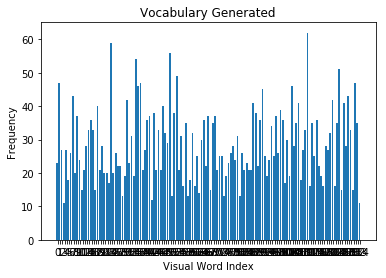

Temps d execution après plot BOV : 2556.546 secondes ---
2529.177777777778
341439.0
0.007407407407407408
--------------------------------- sop test cluster 135 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 160 ---------------------------------
Temps d execution apres Clustering : 2898.92900014 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 2898.94400001 secondes ---
Plotting histogram


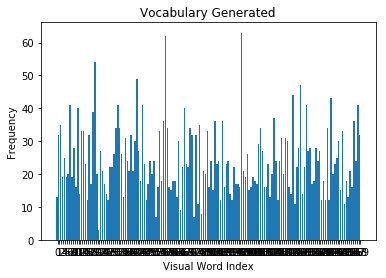

Temps d execution après plot BOV : 2900.227 secondes ---
2133.99375
341439.0
0.00625
--------------------------------- sop test cluster 160 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 185 ---------------------------------
Temps d execution apres Clustering : 3385.21399999 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 3385.21399999 secondes ---
Plotting histogram


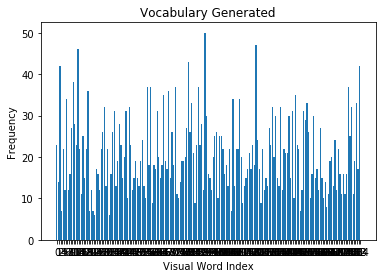

Temps d execution après plot BOV : 3386.47600007 secondes ---
1845.6162162162161
341439.0
0.005405405405405405
--------------------------------- sop test cluster 185 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 210 ---------------------------------
Temps d execution apres Clustering : 3941.58700013 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 3941.602 secondes ---
Plotting histogram


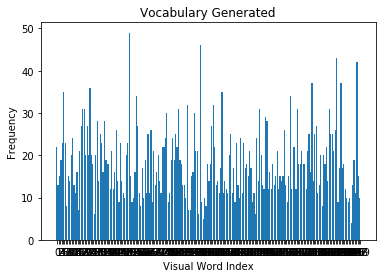

Temps d execution après plot BOV : 3943.14400005 secondes ---
1625.9
341439.0
0.004761904761904762
--------------------------------- sop test cluster 210 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 235 ---------------------------------
Temps d execution apres Clustering : 4208.84399986 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 4208.85899997 secondes ---
Plotting histogram


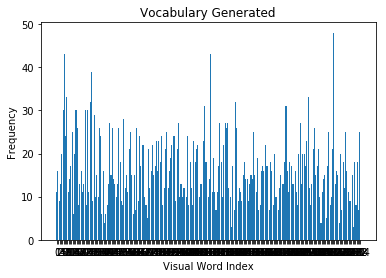

Temps d execution après plot BOV : 4210.43700004 secondes ---
1452.931914893617
341439.0
0.00425531914893617
--------------------------------- sop test cluster 235 ---------------------------------


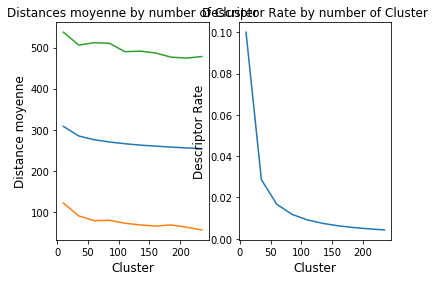

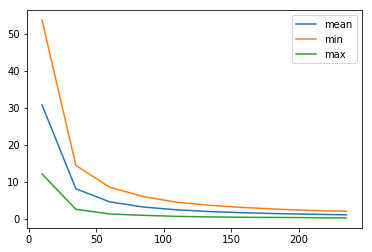

Temps d execution optimisation : 23495.911 secondes ---


In [3]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=50,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

Version : 0.3
Data directory : Data/
Max Number of directory : 0
Max Number of picture by directory : 100
Generator : ORB
Number of feature : 60
Minimum feature size  60
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Computing Features for  n02085936-Maltese_dog
Computing Features for  n02086079-Pekinese
Computing Features for  n02086240-Shih-Tzu
Computing Features for  n02086646-Blenheim_spaniel
Computing Features for  n02086910-papillon
Computing Features for  n02087046-toy_terrier
Computing Features for  n02087394-Rhodesian_ridgeback
Computing Features for  n02088094-Afghan_hound
Computing Features for  n02088238-basset
Computing Features for  n02088364-beagle
Computing Features for  n02088466-bloodhound
Computing Features for  n02088632-bluetick
Computing Features for  n02089078-black-and-tan_coonhound
Computing Features for  n02089867-Walker_hound
Computing Features for  n02089973-English_foxhound
Computing Features for  n02090379-re

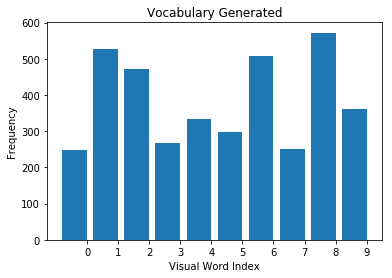

Temps d execution après plot BOV : 264.304999828 secondes ---
68419.2
684192.0
0.09999999999999999
--------------------------------- sop test cluster 10 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 35 ---------------------------------
Temps d execution apres Clustering : 1169.12700009 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 1169.14299989 secondes ---
Plotting histogram


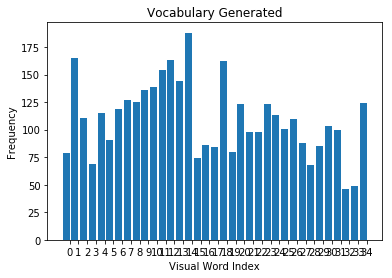

Temps d execution après plot BOV : 1169.40899992 secondes ---
19548.342857142856
684192.0
0.02857142857142857
--------------------------------- sop test cluster 35 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 60 ---------------------------------
Temps d execution apres Clustering : 2327.40300012 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 2327.40300012 secondes ---
Plotting histogram


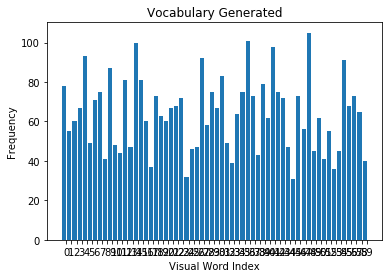

Temps d execution après plot BOV : 2327.88700008 secondes ---
11403.2
684192.0
0.016666666666666666
--------------------------------- sop test cluster 60 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 85 ---------------------------------
Temps d execution apres Clustering : 16126.767 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 16126.779 secondes ---
Plotting histogram


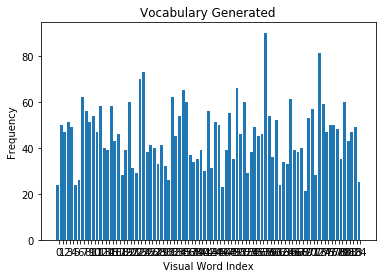

Temps d execution après plot BOV : 16127.5140002 secondes ---
8049.317647058823
684192.0
0.011764705882352941
--------------------------------- sop test cluster 85 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 110 ---------------------------------


In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=100,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=0,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
def generateClusterAndTrainModel(automaticImageIndexing, number_cluster=None, mode_affichage="", number_cluster_to_show=None):
    start_time_cluster = time.time()
    if(number_cluster is None):
        number_cluster = int(10)
    automaticImageIndexing.n_clusters = number_cluster
    
    automaticImageIndexing.clusturing(automaticImageIndexing.n_clusters)
    print("Temps d execution apres Clustering : %s secondes ---" % (time.time() - start_time_cluster))
    mega_histo = automaticImageIndexing.developBagOfVisualWord()
    print("Temps d execution apres BOV : %s secondes ---" % (time.time() - start_time_cluster))
    automaticImageIndexing.plotHist(mega_histo, automaticImageIndexing.n_clusters, None)
    print("Temps d execution après plot BOV : %s secondes ---" % (time.time() - start_time_cluster))

    if number_cluster_to_show is None :
        number_cluster_to_show = int(number_cluster/2)
    showClusterPicture(
        automaticImageIndexing=automaticImageIndexing,
        mode_affichage=mode_affichage,
        number_cluster_to_show=number_cluster_to_show
    )
    print automaticImageIndexing.name_dict
    

    print mega_histo
    automaticImageIndexing.mega_histo = automaticImageIndexing.standardize(mega_histo)
    print mega_histo
    print automaticImageIndexing.mega_histo
    automaticImageIndexing.model_predition = automaticImageIndexing.train( automaticImageIndexing.mega_histo, automaticImageIndexing.name_dict)
    return automaticImageIndexing.model_predition
    

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'

nb_cluster = 2#235

model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=2,#0, 
        number_images=2,#100,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

print("-----------------------------------------------------------------------------------------")
print("--------------------------------- Génération %s cluster - Start ---------------------------------" % str(nb_cluster))
modelPrediction = generateClusterAndTrainModel(
        model,
        number_cluster=nb_cluster
    )
print("--------------------------------- Génération %s cluster - Start ---------------------------------" % str(nb_cluster))